# 02 - Feature Engineering

**Objectif**: Transformer les features brutes en features prêtes pour le machine learning.

**Input**: `train.parquet` et `test.parquet` générés par `build_battle_winner_dataset_v2.py`

**Output**: Features encodées et normalisées, prêtes pour l'entraînement (avec preservation du scenario_type)

**Date**: 2026-01-24

---

## Table des Matières

1. [Chargement des Données](#1-chargement-des-données)
2. [Stratégie de Feature Engineering](#2-stratégie-de-feature-engineering)
3. [Encodage des Features Catégorielles](#3-encodage-des-features-catégorielles)
4. [Normalisation des Features Numériques](#4-normalisation-des-features-numériques)
5. [Création de Features Dérivées](#5-création-de-features-dérivées)
6. [Feature Selection](#6-feature-selection)
7. [Export des Features Finales](#7-export-des-features-finales)
8. [Résumé](#8-résumé)

## 1. Chargement des Données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('default')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Chemins - Dataset v2 (multi-scénarios)
BASE_DIR = Path('../data/ml/battle_winner_v2')
PROCESSED_DIR = BASE_DIR / 'processed'
FEATURES_DIR = BASE_DIR / 'features'
FEATURES_DIR.mkdir(exist_ok=True)

print(f"✅ Bibliothèques chargées")
print(f"✅ Répertoire: {BASE_DIR}")

✅ Bibliothèques chargées
✅ Répertoire: ../data/ml/battle_winner_v2


In [2]:
# Chargement des datasets
df_train = pd.read_parquet(PROCESSED_DIR / 'train.parquet')
df_test = pd.read_parquet(PROCESSED_DIR / 'test.parquet')

print(f"✅ Train set chargé: {df_train.shape}")
print(f"✅ Test set chargé: {df_test.shape}")

# Vérifier scenario_type
if 'scenario_type' in df_train.columns:
    print(f"\n📊 Scénarios détectés:")
    print(df_train['scenario_type'].value_counts())
    print(f"\nℹ️  La colonne 'scenario_type' sera PRÉSERVÉE pour l'analyse mais EXCLUE de l'entraînement du modèle")
    PRESERVE_SCENARIO = True
else:
    PRESERVE_SCENARIO = False

# Séparer features et target
X_train_full = df_train.drop(columns=['winner'])
y_train = df_train['winner']

X_test_full = df_test.drop(columns=['winner'])
y_test = df_test['winner']

print(f"\n✅ X_train: {X_train_full.shape}")
print(f"✅ y_train: {y_train.shape}")
print(f"✅ X_test: {X_test_full.shape}")
print(f"✅ y_test: {y_test.shape}")

if PRESERVE_SCENARIO:
    print(f"\nℹ️  Note: 'scenario_type' est inclus dans X pour l'instant (sera retiré avant modélisation)")

✅ Train set chargé: (718889, 39)
✅ Test set chargé: (179723, 39)

📊 Scénarios détectés:
scenario_type
all_combinations    551936
random_move         139128
best_move            27825
Name: count, dtype: int64

ℹ️  La colonne 'scenario_type' sera PRÉSERVÉE pour l'analyse mais EXCLUE de l'entraînement du modèle

✅ X_train: (718889, 38)
✅ y_train: (718889,)
✅ X_test: (179723, 38)
✅ y_test: (179723,)

ℹ️  Note: 'scenario_type' est inclus dans X pour l'instant (sera retiré avant modélisation)


## 2. Stratégie de Feature Engineering

### Objectif

Prédire le gagnant d'un combat Pokémon 1v1 basé sur:
- Les stats des deux Pokémon
- Leurs types
- Les meilleurs moves sélectionnés
- Les avantages de type et STAB

### Features à Traiter

1. **Features Catégorielles**: Types Pokémon, Types de Move
2. **Features Numériques**: Stats, Puissance, Priorité
3. **Features Dérivées**: Ratios, Différences, Interactions

In [3]:
# Identifier les types de features
print("=" * 80)
print("📋 INVENTAIRE DES FEATURES")
print("=" * 80)

# Features à exclure (IDs et noms)
id_features = ['pokemon_a_id', 'pokemon_b_id', 'pokemon_a_name', 'pokemon_b_name', 'a_move_name', 'b_move_name']

# Sauvegarder scenario_type si présent (on le réintégrera après le feature engineering)
scenario_train = None
scenario_test = None
if PRESERVE_SCENARIO and 'scenario_type' in X_train_full.columns:
    scenario_train = X_train_full['scenario_type'].copy()
    scenario_test = X_test_full['scenario_type'].copy()
    print(f"✅ scenario_type sera préservé pour l'analyse")

# Retirer scenario_type des features pour l'entraînement
columns_to_drop = id_features.copy()
if PRESERVE_SCENARIO and 'scenario_type' in X_train_full.columns:
    columns_to_drop.append('scenario_type')

X_train = X_train_full.drop(columns=[col for col in columns_to_drop if col in X_train_full.columns])
X_test = X_test_full.drop(columns=[col for col in columns_to_drop if col in X_test_full.columns])

# Features catégorielles
categorical_features = [
    'a_type_1', 'a_type_2',
    'b_type_1', 'b_type_2',
    'a_move_type', 'b_move_type'
]

# Features numériques (stats Pokémon)
stat_features_a = ['a_hp', 'a_attack', 'a_defense', 'a_sp_attack', 'a_sp_defense', 'a_speed']
stat_features_b = ['b_hp', 'b_attack', 'b_defense', 'b_sp_attack', 'b_sp_defense', 'b_speed']

# Features numériques (moves)
move_features = [
    'a_move_power', 'a_move_priority', 'a_move_stab', 'a_move_type_mult',
    'b_move_power', 'b_move_priority', 'b_move_stab', 'b_move_type_mult'
]

# Features dérivées existantes
derived_features = ['speed_diff', 'hp_diff', 'a_total_stats', 'b_total_stats', 'a_moves_first']

print(f"\nIDs/Noms (exclus): {len([col for col in id_features if col in X_train_full.columns])} colonnes")
if scenario_train is not None:
    print(f"Scénario (préservé séparément): scenario_type")
print(f"\nCatégorielles ({len([col for col in categorical_features if col in X_train.columns])}): {[col for col in categorical_features if col in X_train.columns]}")
print(f"Stats A ({len([col for col in stat_features_a if col in X_train.columns])}): {[col for col in stat_features_a if col in X_train.columns]}")
print(f"Stats B ({len([col for col in stat_features_b if col in X_train.columns])}): {[col for col in stat_features_b if col in X_train.columns]}")
print(f"Moves ({len([col for col in move_features if col in X_train.columns])}): {[col for col in move_features if col in X_train.columns]}")
print(f"Dérivées ({len([col for col in derived_features if col in X_train.columns])}): {[col for col in derived_features if col in X_train.columns]}")

📋 INVENTAIRE DES FEATURES
✅ scenario_type sera préservé pour l'analyse

IDs/Noms (exclus): 6 colonnes
Scénario (préservé séparément): scenario_type

Catégorielles (6): ['a_type_1', 'a_type_2', 'b_type_1', 'b_type_2', 'a_move_type', 'b_move_type']
Stats A (6): ['a_hp', 'a_attack', 'a_defense', 'a_sp_attack', 'a_sp_defense', 'a_speed']
Stats B (6): ['b_hp', 'b_attack', 'b_defense', 'b_sp_attack', 'b_sp_defense', 'b_speed']
Moves (8): ['a_move_power', 'a_move_priority', 'a_move_stab', 'a_move_type_mult', 'b_move_power', 'b_move_priority', 'b_move_stab', 'b_move_type_mult']
Dérivées (5): ['speed_diff', 'hp_diff', 'a_total_stats', 'b_total_stats', 'a_moves_first']


## 3. Encodage des Features Catégorielles

### Stratégie d'Encodage

- **One-Hot Encoding** pour les types (Pokemon et Move)
- Note: Les types ont ~17-18 valeurs + "none" pour le type secondaire

In [4]:
# Copie des datasets pour transformation
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

print("=" * 80)
print("🔤 ENCODAGE DES FEATURES CATÉGORIELLES")
print("=" * 80)

🔤 ENCODAGE DES FEATURES CATÉGORIELLES


In [5]:
# One-Hot Encoding pour les types
print("\n1️⃣ One-Hot Encoding: Types")

type_features = ['a_type_1', 'a_type_2', 'b_type_1', 'b_type_2', 'a_move_type', 'b_move_type']

for feature in type_features:
    if feature in X_train_encoded.columns:
        print(f"   Encodage de {feature}...")
        
        # One-hot encoding avec get_dummies
        train_dummies = pd.get_dummies(X_train_encoded[feature], prefix=feature, drop_first=False)
        test_dummies = pd.get_dummies(X_test_encoded[feature], prefix=feature, drop_first=False)
        
        # Aligner les colonnes (au cas où certaines valeurs n'existent que dans train ou test)
        train_dummies, test_dummies = train_dummies.align(test_dummies, join='left', axis=1, fill_value=0)
        
        # Ajouter au dataset
        X_train_encoded = pd.concat([X_train_encoded, train_dummies], axis=1)
        X_test_encoded = pd.concat([X_test_encoded, test_dummies], axis=1)
        
        print(f"   → {len(train_dummies.columns)} colonnes créées")

print(f"\n✅ Shape après encodage: Train={X_train_encoded.shape}, Test={X_test_encoded.shape}")


1️⃣ One-Hot Encoding: Types
   Encodage de a_type_1...
   → 17 colonnes créées
   Encodage de a_type_2...
   → 16 colonnes créées
   Encodage de b_type_1...
   → 17 colonnes créées
   Encodage de b_type_2...
   → 16 colonnes créées
   Encodage de a_move_type...
   → 18 colonnes créées
   Encodage de b_move_type...
   → 18 colonnes créées

✅ Shape après encodage: Train=(718889, 133), Test=(179723, 133)


In [6]:
# Supprimer les colonnes catégorielles originales et les IDs
# Note: scenario_type a déjà été sauvegardé dans scenario_train/scenario_test à la cellule précédente
columns_to_drop = type_features + id_features
columns_to_drop = [col for col in columns_to_drop if col in X_train_encoded.columns]

X_train_encoded.drop(columns=columns_to_drop, inplace=True)
X_test_encoded.drop(columns=columns_to_drop, inplace=True)

print(f"✅ Colonnes catégorielles et IDs supprimées")
print(f"   Shape: Train={X_train_encoded.shape}, Test={X_test_encoded.shape}")

if scenario_train is not None:
    print(f"ℹ️  scenario_type sauvegardé séparément, sera réintégré à la fin")

✅ Colonnes catégorielles et IDs supprimées
   Shape: Train=(718889, 127), Test=(179723, 127)
ℹ️  scenario_type sauvegardé séparément, sera réintégré à la fin


## 4. Normalisation des Features Numériques

Normalisation avec **StandardScaler** pour les features de stats.

In [7]:
print("=" * 80)
print("📐 NORMALISATION DES FEATURES NUMÉRIQUES")
print("=" * 80)

# Features à normaliser (stats)
features_to_scale = [
    'a_hp', 'a_attack', 'a_defense', 'a_sp_attack', 'a_sp_defense', 'a_speed',
    'b_hp', 'b_attack', 'b_defense', 'b_sp_attack', 'b_sp_defense', 'b_speed',
    'a_move_power', 'b_move_power',
    'a_total_stats', 'b_total_stats',
    'speed_diff', 'hp_diff'
]

# Garder seulement les colonnes existantes
features_to_scale = [f for f in features_to_scale if f in X_train_encoded.columns]

# Initialiser le scaler
scaler = StandardScaler()

# Fit sur train, transform sur train et test
X_train_encoded[features_to_scale] = scaler.fit_transform(X_train_encoded[features_to_scale])
X_test_encoded[features_to_scale] = scaler.transform(X_test_encoded[features_to_scale])

print(f"✅ {len(features_to_scale)} features normalisées")
print(f"\nMoyennes après normalisation (train):")
print(X_train_encoded[features_to_scale[:6]].mean())
print(f"\nÉcarts-types après normalisation (train):")
print(X_train_encoded[features_to_scale[:6]].std())

📐 NORMALISATION DES FEATURES NUMÉRIQUES
✅ 18 features normalisées

Moyennes après normalisation (train):
a_hp           -2.138481e-16
a_attack        5.001254e-18
a_defense       6.301975e-17
a_sp_attack    -2.055851e-17
a_sp_defense    7.907120e-20
a_speed         9.045746e-17
dtype: float64

Écarts-types après normalisation (train):
a_hp            1.000001
a_attack        1.000001
a_defense       1.000001
a_sp_attack     1.000001
a_sp_defense    1.000001
a_speed         1.000001
dtype: float64


## 5. Création de Features Dérivées

### Features d'Interaction

Création de nouvelles features par combinaison:
1. **stat_ratio**: Ratio des stats totales A/B
2. **damage_potential_diff**: Différence de potentiel de dégâts
3. **type_advantage_diff**: Différence d'avantage de type
4. **effective_power_a/b**: Puissance × STAB × Type mult

In [8]:
print("=" * 80)
print("🔧 CRÉATION DE FEATURES DÉRIVÉES")
print("=" * 80)

# Feature 1: Ratio des stats totales
# Note: On utilise les valeurs originales avant normalisation pour le ratio
X_train_encoded['stat_ratio'] = df_train['a_total_stats'] / (df_train['b_total_stats'] + 1)
X_test_encoded['stat_ratio'] = df_test['a_total_stats'] / (df_test['b_total_stats'] + 1)
print("✅ Feature créée: stat_ratio")

# Feature 2: Différence d'avantage de type
X_train_encoded['type_advantage_diff'] = df_train['a_move_type_mult'] - df_train['b_move_type_mult']
X_test_encoded['type_advantage_diff'] = df_test['a_move_type_mult'] - df_test['b_move_type_mult']
print("✅ Feature créée: type_advantage_diff")

# Feature 3: Puissance effective A (power × STAB × type_mult)
X_train_encoded['effective_power_a'] = df_train['a_move_power'] * df_train['a_move_stab'] * df_train['a_move_type_mult']
X_test_encoded['effective_power_a'] = df_test['a_move_power'] * df_test['a_move_stab'] * df_test['a_move_type_mult']
print("✅ Feature créée: effective_power_a")

# Feature 4: Puissance effective B
X_train_encoded['effective_power_b'] = df_train['b_move_power'] * df_train['b_move_stab'] * df_train['b_move_type_mult']
X_test_encoded['effective_power_b'] = df_test['b_move_power'] * df_test['b_move_stab'] * df_test['b_move_type_mult']
print("✅ Feature créée: effective_power_b")

# Feature 5: Différence de puissance effective
X_train_encoded['effective_power_diff'] = X_train_encoded['effective_power_a'] - X_train_encoded['effective_power_b']
X_test_encoded['effective_power_diff'] = X_test_encoded['effective_power_a'] - X_test_encoded['effective_power_b']
print("✅ Feature créée: effective_power_diff")

# Feature 6: Avantage de priorité
X_train_encoded['priority_advantage'] = df_train['a_move_priority'] - df_train['b_move_priority']
X_test_encoded['priority_advantage'] = df_test['a_move_priority'] - df_test['b_move_priority']
print("✅ Feature créée: priority_advantage")

print(f"\n✅ Shape après création de features: Train={X_train_encoded.shape}, Test={X_test_encoded.shape}")

🔧 CRÉATION DE FEATURES DÉRIVÉES
✅ Feature créée: stat_ratio
✅ Feature créée: type_advantage_diff
✅ Feature créée: effective_power_a
✅ Feature créée: effective_power_b
✅ Feature créée: effective_power_diff
✅ Feature créée: priority_advantage

✅ Shape après création de features: Train=(718889, 133), Test=(179723, 133)


In [9]:
# Normaliser les nouvelles features dérivées
new_features = ['stat_ratio', 'type_advantage_diff', 'effective_power_a', 'effective_power_b', 
                'effective_power_diff', 'priority_advantage']

scaler_new = StandardScaler()
X_train_encoded[new_features] = scaler_new.fit_transform(X_train_encoded[new_features])
X_test_encoded[new_features] = scaler_new.transform(X_test_encoded[new_features])

print("✅ Nouvelles features normalisées")

✅ Nouvelles features normalisées


## 6. Feature Selection

### Analyse de l'Importance des Features

Utilisation de **Mutual Information** pour mesurer la dépendance entre chaque feature et la cible.

In [10]:
print("=" * 80)
print("🎯 ANALYSE DE L'IMPORTANCE DES FEATURES (MUTUAL INFORMATION)")
print("=" * 80)

# Calculer mutual information
mi_scores = mutual_info_classif(
    X_train_encoded,
    y_train,
    random_state=42,
    n_neighbors=5
)

# Créer DataFrame avec scores
mi_df = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("\n📊 Top 25 Features par Mutual Information:")
print(mi_df.head(25).to_string(index=False))

🎯 ANALYSE DE L'IMPORTANCE DES FEATURES (MUTUAL INFORMATION)

📊 Top 25 Features par Mutual Information:
             Feature  MI_Score
          stat_ratio  0.226390
             hp_diff  0.150039
effective_power_diff  0.141394
       a_total_stats  0.103017
       b_total_stats  0.091858
 type_advantage_diff  0.087616
                a_hp  0.086322
   effective_power_a  0.084857
                b_hp  0.078311
            a_attack  0.076616
           a_defense  0.074680
   effective_power_b  0.069126
            b_attack  0.068137
           b_defense  0.066390
        a_sp_defense  0.066109
    a_move_type_mult  0.065054
        b_sp_defense  0.057383
    b_move_type_mult  0.055082
         a_sp_attack  0.054449
         b_sp_attack  0.049361
        a_move_power  0.039632
       b_type_2_none  0.036607
       a_moves_first  0.036354
       a_type_2_none  0.035665
             a_speed  0.032174


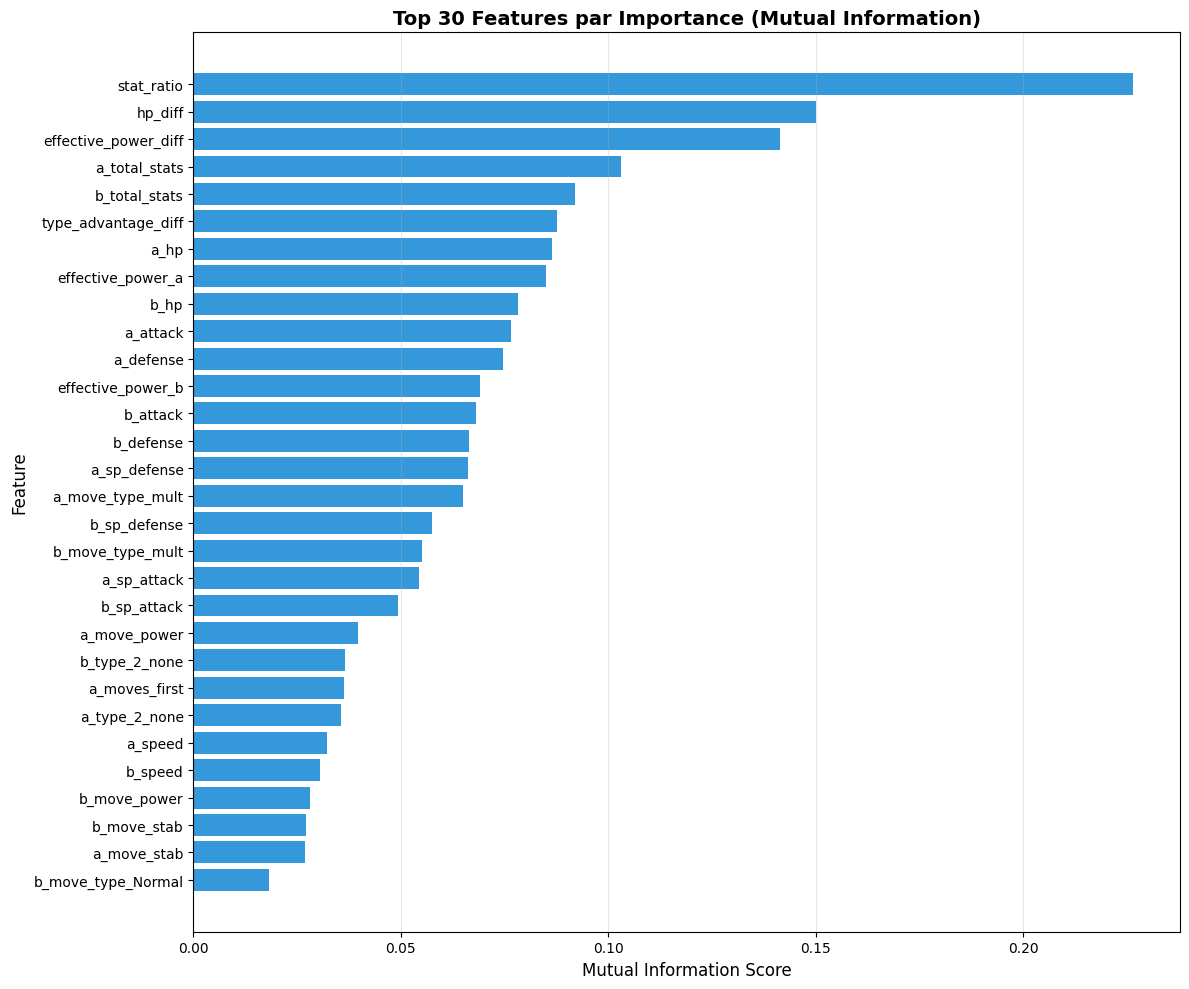


✅ Feature avec le score MI le plus élevé: stat_ratio (0.2264)


In [11]:
# Visualisation des top features
fig, ax = plt.subplots(figsize=(12, 10))
top_30 = mi_df.head(30)
ax.barh(top_30['Feature'], top_30['MI_Score'], color='#3498db')
ax.set_xlabel('Mutual Information Score', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Top 30 Features par Importance (Mutual Information)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ Feature avec le score MI le plus élevé: {mi_df.iloc[0]['Feature']} ({mi_df.iloc[0]['MI_Score']:.4f})")

### 6.1 Feature Importance par Scénario

In [12]:
if scenario_train is not None:
    print("\n" + "=" * 80)
    print("🔍 ANALYSE DE FEATURE IMPORTANCE PAR SCÉNARIO")
    print("=" * 80)
    
    # Pour chaque scénario, calculer la mutual information
    scenarios = scenario_train.unique()
    scenario_mi_results = {}
    
    for scenario in scenarios:
        print(f"\n📊 Scénario: {scenario}")
        
        # Filtrer les données par scénario
        mask_train = scenario_train == scenario
        X_scenario = X_train_encoded[mask_train]
        y_scenario = y_train[mask_train]
        
        # Calculer MI pour ce scénario
        mi_scores_scenario = mutual_info_classif(
            X_scenario,
            y_scenario,
            random_state=42,
            n_neighbors=5
        )
        
        scenario_mi_results[scenario] = pd.DataFrame({
            'Feature': X_train_encoded.columns,
            'MI_Score': mi_scores_scenario
        }).sort_values('MI_Score', ascending=False)
        
        print(f"   ✅ Top 5 features:")
        for idx, row in scenario_mi_results[scenario].head(5).iterrows():
            print(f"      {row['Feature']:40s} → {row['MI_Score']:.4f}")
else:
    print("\n⚠️ Dataset v1 - pas d'analyse par scénario disponible")


🔍 ANALYSE DE FEATURE IMPORTANCE PAR SCÉNARIO

📊 Scénario: all_combinations
   ✅ Top 5 features:
      stat_ratio                               → 0.2296
      hp_diff                                  → 0.1512
      effective_power_diff                     → 0.1339
      a_total_stats                            → 0.0996
      b_total_stats                            → 0.0992

📊 Scénario: random_move
   ✅ Top 5 features:
      stat_ratio                               → 0.2582
      hp_diff                                  → 0.1639
      a_total_stats                            → 0.1386
      effective_power_diff                     → 0.1175
      a_hp                                     → 0.1154

📊 Scénario: best_move
   ✅ Top 5 features:
      stat_ratio                               → 0.3009
      hp_diff                                  → 0.2379
      b_total_stats                            → 0.1327
      a_total_stats                            → 0.1279
      a_hp                   


📊 Comparaison visuelle des top 15 features par scénario


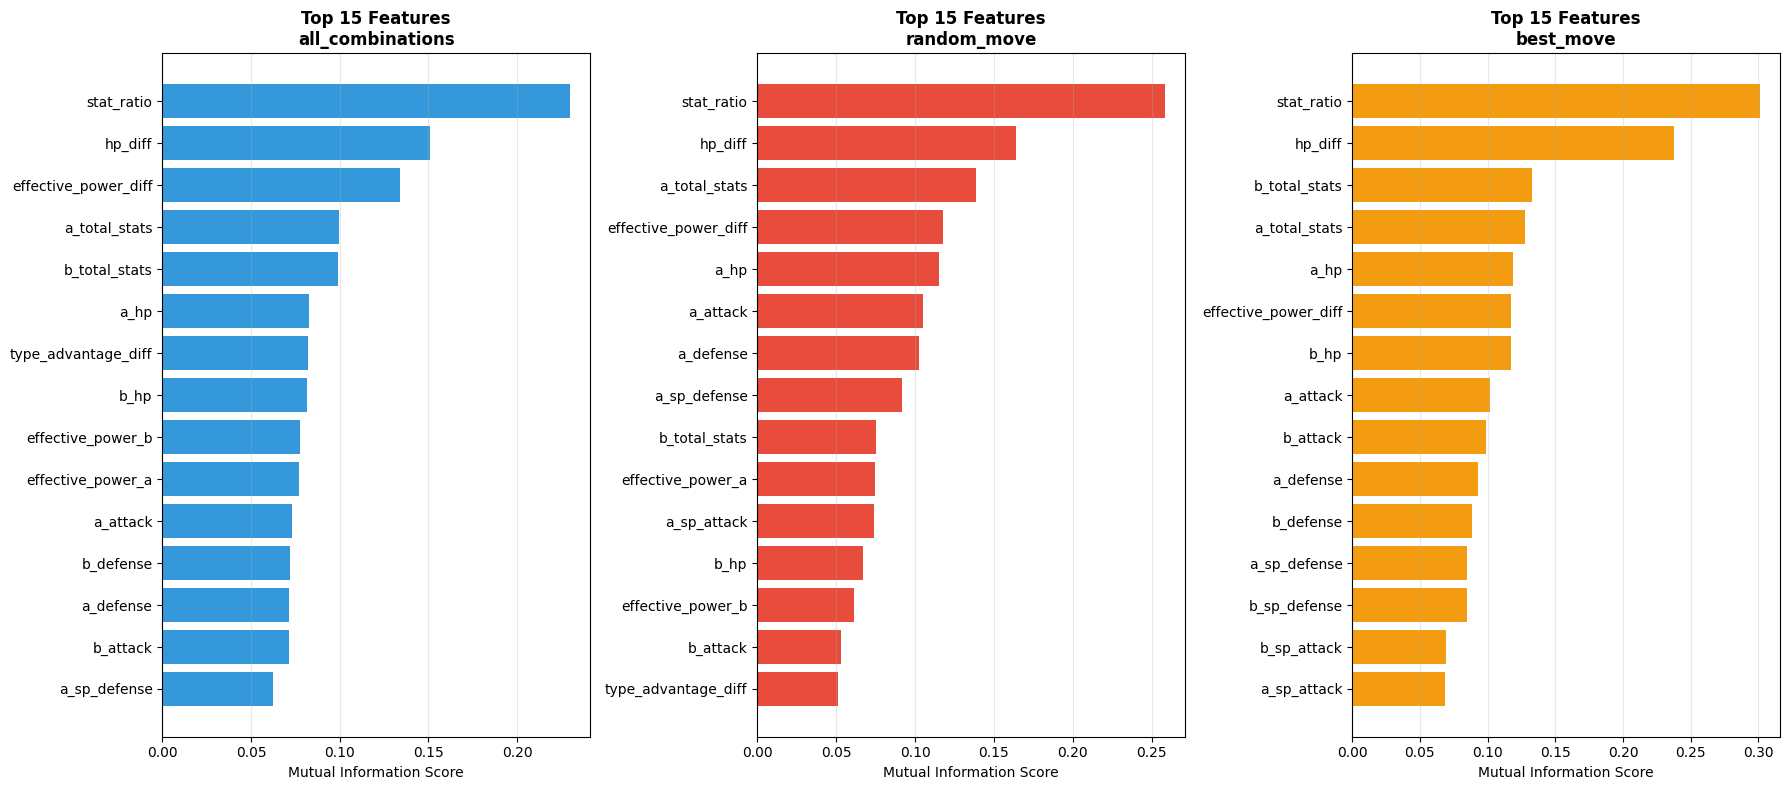


🔍 Features communes dans le top 10 de tous les scénarios:
   ✅ 6 features communes:
      - effective_power_diff
      - a_total_stats
      - b_total_stats
      - a_hp
      - hp_diff
      - stat_ratio


In [13]:
if scenario_train is not None:
    # Comparaison visuelle des top features par scénario
    print("\n📊 Comparaison visuelle des top 15 features par scénario")
    
    n_top = 15
    fig, axes = plt.subplots(1, len(scenarios), figsize=(6*len(scenarios), 8))
    if len(scenarios) == 1:
        axes = [axes]
    
    for idx, scenario in enumerate(scenarios):
        top_features = scenario_mi_results[scenario].head(n_top)
        axes[idx].barh(top_features['Feature'], top_features['MI_Score'], 
                       color=['#3498db', '#e74c3c', '#f39c12'][idx % 3])
        axes[idx].set_xlabel('Mutual Information Score', fontsize=10)
        axes[idx].set_title(f'Top {n_top} Features\n{scenario}', fontsize=12, fontweight='bold')
        axes[idx].invert_yaxis()
        axes[idx].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Identifier les features communes dans le top 10 de chaque scénario
    print("\n🔍 Features communes dans le top 10 de tous les scénarios:")
    top_10_sets = [set(scenario_mi_results[s].head(10)['Feature'].tolist()) for s in scenarios]
    common_features = set.intersection(*top_10_sets)
    
    if common_features:
        print(f"   ✅ {len(common_features)} features communes:")
        for feat in common_features:
            print(f"      - {feat}")
    else:
        print("   ⚠️ Aucune feature commune dans le top 10 de tous les scénarios")

## 7. Export des Features Finales

In [14]:
print("=" * 80)
print("💾 EXPORT DES FEATURES FINALES")
print("=" * 80)

# Réintégrer scenario_type si présent
if scenario_train is not None:
    X_train_encoded['scenario_type'] = scenario_train
    X_test_encoded['scenario_type'] = scenario_test
    print(f"✅ scenario_type réintégré dans les datasets finaux")

print(f"\n1️⃣ Features complètes")
print(f"   Train shape: {X_train_encoded.shape}")
print(f"   Test shape: {X_test_encoded.shape}")
if scenario_train is not None:
    print(f"   ✅ Inclut scenario_type pour analyse multi-scénarios")

# Export features
X_train_encoded.to_parquet(FEATURES_DIR / 'X_train.parquet', index=False)
X_test_encoded.to_parquet(FEATURES_DIR / 'X_test.parquet', index=False)
y_train.to_frame().to_parquet(FEATURES_DIR / 'y_train.parquet', index=False)
y_test.to_frame().to_parquet(FEATURES_DIR / 'y_test.parquet', index=False)

print(f"   ✅ Exporté: X_train.parquet")
print(f"   ✅ Exporté: X_test.parquet")
print(f"   ✅ Exporté: y_train.parquet")
print(f"   ✅ Exporté: y_test.parquet")

💾 EXPORT DES FEATURES FINALES
✅ scenario_type réintégré dans les datasets finaux

1️⃣ Features complètes
   Train shape: (718889, 134)
   Test shape: (179723, 134)
   ✅ Inclut scenario_type pour analyse multi-scénarios
   ✅ Exporté: X_train.parquet
   ✅ Exporté: X_test.parquet
   ✅ Exporté: y_train.parquet
   ✅ Exporté: y_test.parquet


In [15]:
# Sauvegarder les objets de transformation (scalers)
import joblib

joblib.dump(scaler, FEATURES_DIR / 'standard_scaler.pkl')
joblib.dump(scaler_new, FEATURES_DIR / 'standard_scaler_new_features.pkl')

print("\n2️⃣ Objets de transformation")
print("   ✅ Exporté: standard_scaler.pkl")
print("   ✅ Exporté: standard_scaler_new_features.pkl")


2️⃣ Objets de transformation
   ✅ Exporté: standard_scaler.pkl
   ✅ Exporté: standard_scaler_new_features.pkl


In [16]:
# Sauvegarder la liste des features
feature_list = X_train_encoded.columns.tolist()
joblib.dump(feature_list, FEATURES_DIR / 'feature_list.pkl')

print(f"\n3️⃣ Liste des features ({len(feature_list)} features)")
print("   ✅ Exporté: feature_list.pkl")

# Afficher les fichiers créés
print(f"\n📁 Fichiers dans {FEATURES_DIR}:")
for f in FEATURES_DIR.iterdir():
    print(f"   - {f.name} ({f.stat().st_size / 1024:.1f} KB)")


3️⃣ Liste des features (134 features)
   ✅ Exporté: feature_list.pkl

📁 Fichiers dans ../data/ml/battle_winner_v2/features:
   - feature_list.pkl (2.3 KB)
   - X_train.parquet (19416.3 KB)
   - X_test.parquet (4984.0 KB)
   - standard_scaler.pkl (1.4 KB)
   - y_train.parquet (91.5 KB)
   - y_test.parquet (23.8 KB)
   - standard_scaler_new_features.pkl (1.1 KB)


## 8. Résumé

### Transformations Effectuées

#### ✅ Encodage des Features Catégorielles
- **One-Hot Encoding** pour les types Pokémon et types de Move
- 6 features catégorielles transformées en ~100 colonnes binaires

#### ✅ Normalisation
- **StandardScaler** appliqué sur les features numériques
- Stats, puissances, et features dérivées normalisées

#### ✅ Features Dérivées (6 nouvelles)
1. **stat_ratio**: Ratio des stats totales A/B
2. **type_advantage_diff**: Différence d'avantage de type
3. **effective_power_a**: Puissance × STAB × Type mult (A)
4. **effective_power_b**: Puissance × STAB × Type mult (B)
5. **effective_power_diff**: Différence de puissance effective
6. **priority_advantage**: Différence de priorité des moves

#### ✅ Feature Selection
- Analyse avec **Mutual Information**
- Features les plus importantes identifiées

---

### Datasets Générés

- `X_train.parquet` - Features d'entraînement
- `X_test.parquet` - Features de test
- `y_train.parquet` - Labels d'entraînement
- `y_test.parquet` - Labels de test

**Transformers**:
- `standard_scaler.pkl`
- `standard_scaler_new_features.pkl`
- `feature_list.pkl`

---

### Prochaine Étape

**Notebook 03: Training & Evaluation**
- Entraîner plusieurs modèles (Random Forest, XGBoost)
- Évaluer les performances (Accuracy, F1, ROC-AUC)
- Analyser les features importantes
- Sélectionner le meilleur modèle pour la production

**✅ Features prêtes pour le machine learning!**